# CPSC 330 Lecture 17

Lecture plan:

- Announcements
- Follow-up from last class: more time encodings (5 min)
- Our standard approach (10 min)
- Censoring and survival analysis (15 min)
- Kaplan-Meier curve (10 min)
- Break (5 min)
- Cox proportional hazards model (15 min)
- Prediction (10 min)
- T/F questions (10 min)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
from sklearn.metrics import plot_confusion_matrix

In [3]:
plt.rcParams['font.size'] = 16

New dependency: `lifelines`. Install with

`pip install lifelines`

or

`conda install -c conda-forge lifelines`

In [4]:
import lifelines

In [5]:
# does lifelines try to mess with this?
pd.options.display.max_rows = 10

## Announcements

- UBC is preparing to move online due to COVID-19.
  - But I can't predict if/when it will happen.
  - I hope it happens soon.
- Regardless of what UBC decides, I may do so starting next week. 
  - If so, I will post screencasts for you to watch. 
  - I will post them by the time class would have started, so you can spend the scheduled time watching, if you'd like.
  - I'll be paying close attention to Piazza. 
  - This would improve everyone's safety. 

## Follow-up from last class: more time encodings (5 min)

See Lecture 16 notebook.

## Customer churn: our standard approach (10 min)

- In hw4 you looked at a dataset about [customer churn](https://en.wikipedia.org/wiki/Customer_attrition).
- In hw4, the dataset was interesting because it's unbalanced (most customers stay). 
- Today we'll look at a different customer churn [dataset](https://www.kaggle.com/blastchar/telco-customer-churn), because it has a feature we need - time!
- We'll explore the time aspect of the dataset today.

In [6]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_train, df_test = train_test_split(df)
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3491,4682-BLBUC,Male,0,Yes,No,44,Yes,No,DSL,No,...,Yes,Yes,Yes,No,One year,Yes,Electronic check,70.95,3250.45,No
631,9931-KGHOA,Female,0,Yes,No,46,Yes,Yes,DSL,Yes,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),55.00,2473.95,No
2381,7649-PHJVR,Male,0,No,No,11,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,226.8,No
2347,7089-RKVSZ,Male,0,Yes,Yes,8,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,24.40,203.95,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No


We are trying to predict `Churn` (yes/no) from these other columns.

In [7]:
df_train.shape

(5282, 21)

In [8]:
df_train["Churn"].value_counts()

No     3885
Yes    1397
Name: Churn, dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3491 to 149
Data columns (total 21 columns):
customerID          5282 non-null object
gender              5282 non-null object
SeniorCitizen       5282 non-null int64
Partner             5282 non-null object
Dependents          5282 non-null object
tenure              5282 non-null int64
PhoneService        5282 non-null object
MultipleLines       5282 non-null object
InternetService     5282 non-null object
OnlineSecurity      5282 non-null object
OnlineBackup        5282 non-null object
DeviceProtection    5282 non-null object
TechSupport         5282 non-null object
StreamingTV         5282 non-null object
StreamingMovies     5282 non-null object
Contract            5282 non-null object
PaperlessBilling    5282 non-null object
PaymentMethod       5282 non-null object
MonthlyCharges      5282 non-null float64
TotalCharges        5282 non-null object
Churn               5282 non-null object
dtypes: float64(1), int64(2), o

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [10]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
drop_features    = ['customerID']
target_column    = ['Churn']
# the rest are categorical
categorical_features = list(set(df_train.columns)-set(numeric_features)-set(drop_features)-set(target_column))

In [11]:
feature_transformers = [
    ('scale',  StandardScaler(), numeric_features),
    ('ohe',    OneHotEncoder(drop='first', sparse=False), categorical_features) ]

In [12]:
feature_preprocessor = ColumnTransformer(transformers=feature_transformers)

In [13]:
feature_preprocessor.fit(df_train);

ValueError: could not convert string to float: 

Hmmm, one of the numeric features is causing problems?

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Oh, looks like `TotalCharges` is not a numeric type.

In [15]:
df_train['TotalCharges'] = df_train['TotalCharges'].astype(float)

ValueError: could not convert string to float: 

Argh!!

In [16]:
for val in df_train['TotalCharges']:
    try: 
        float(val)
    except ValueError:
        print(val)

Any ideas?

<br><br><br><br><br><br>

Well, it turns out we can't see those problematic values because they are whitespace!

In [18]:
for val in df_train['TotalCharges']:
    try: 
        float(val)
    except ValueError:
        print('"%s"' % val)

" "
" "
" "
" "
" "
" "
" "
" "
" "
" "


In [19]:
df_train['TotalCharges'] = df_train['TotalCharges'].replace(" ", np.nan)
df_test['TotalCharges']  = df_test['TotalCharges'].replace(" ", np.nan)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
df_train['TotalCharges'] = df_train['TotalCharges'].astype(float)
df_test['TotalCharges'] = df_test['TotalCharges'].astype(float)

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mgelbart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now that worked. But now we need to do imputation.

In [21]:
imp = SimpleImputer(strategy='median')
imp.fit(df_train[['TotalCharges']])

df_train_imp = df_train.copy()
df_test_imp = df_test.copy()

df_train_imp['TotalCharges'] = imp.transform(df_train[['TotalCharges']])
df_test_imp['TotalCharges'] = imp.transform(df_test[['TotalCharges']])

Now let's try that again...

In [22]:
feature_preprocessor.fit(df_train_imp);

In [23]:
new_columns = numeric_features + list(feature_preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))
new_columns;
# NOTE: the order here must match the order above

In [24]:
X_train = pd.DataFrame(feature_preprocessor.transform(df_train_imp), index=df_train_imp.index, columns=new_columns)
X_test  = pd.DataFrame(feature_preprocessor.transform(df_test_imp),  index=df_test_imp.index,  columns=new_columns)

In [25]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,TechSupport_No internet service,TechSupport_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,gender_Male,Dependents_Yes,OnlineSecurity_No internet service,...,StreamingTV_Yes,PhoneService_Yes,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
3491,0.466333,0.197727,0.418098,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
631,0.547595,-0.334614,0.076472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2381,-0.874488,-1.519448,-0.912178,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2347,-0.996381,-1.355908,-0.922231,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5218,-1.321428,-1.512773,-0.393391,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3491 to 149
Data columns (total 30 columns):
tenure                                   5282 non-null float64
MonthlyCharges                           5282 non-null float64
TotalCharges                             5282 non-null float64
TechSupport_No internet service          5282 non-null float64
TechSupport_Yes                          5282 non-null float64
OnlineBackup_No internet service         5282 non-null float64
OnlineBackup_Yes                         5282 non-null float64
gender_Male                              5282 non-null float64
Dependents_Yes                           5282 non-null float64
OnlineSecurity_No internet service       5282 non-null float64
OnlineSecurity_Yes                       5282 non-null float64
SeniorCitizen_1                          5282 non-null float64
PaymentMethod_Credit card (automatic)    5282 non-null float64
PaymentMethod_Electronic check           5282 non-null float64
PaymentMe

In [27]:
y_train = df_train["Churn"]
y_test = df_test["Churn"]

Yikes! Ok, let's get some scores...

In [28]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train);

In [29]:
dc.score(X_train, y_train)

0.7355168496781522

In [30]:
dc.score(X_test, y_test)

0.7319704713231119

In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

In [32]:
lr.score(X_train, y_train)

0.8065126845891708

In [33]:
lr.score(X_test, y_test)

0.8069278818852924

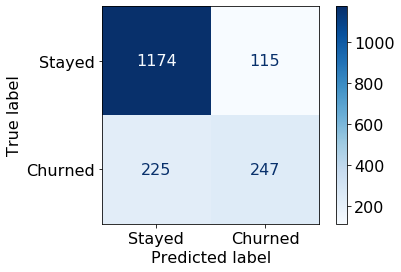

In [34]:
plot_confusion_matrix(lr, X_test, y_test,
                      display_labels=['Stayed', 'Churned'],
                      cmap=plt.cm.Blues, values_format = 'd');

In [35]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [36]:
rf.score(X_train, y_train)

0.9986747444149944

In [37]:
rf.score(X_test, y_test)

0.7955706984667802

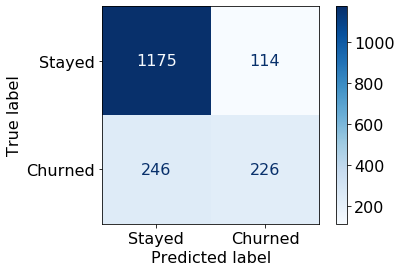

In [38]:
plot_confusion_matrix(rf, X_test, y_test,
                      display_labels=['Stayed', 'Churned'],
                      cmap=plt.cm.Blues, values_format = 'd');

And now the rest of the class is about what is wrong with what we just did!

## Censoring and survival analysis (15 min)

#### Time to event and censoring

Imagine that you want to analyze _the time until an event occurs_. For example,

- the time until a disease kills its host.
- the time until a piece of equipment breaks.
- the time that someone unemployed will take to land a new job.
- the time until a customer leaves a subscription service (this dataset).

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". The important thing is to understand that we are interested in **the time until something happens**, or whether or not something will happen in a certain time frame.

**Question:** But why is this different? Can't you just use the techniques you learned so far (e.g., regression models)? Take a minute to think about this.

<br><br><br><br><br><br>

The answer would be yes if you could observe the actual time in all occurrences, but you usually cannot. Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied.

#### Why talk about censoring: coronavirus.

- According to [this article](https://www.livescience.com/new-china-coronavirus-faq.html) the first reported case of coronavirus was on December 31, 2019.
- Over 100,000 people have already been infected by the coronavirus. Out of those, about 4,000 people have died. 
- We are trying to measure the time until the death of people that contracted the coronavirus.
  - We have this time for 4,000 people, who, unfortunately, have died.  
  - For the other 100,000 infected people, know that 66,000 have recovered.
  - For the remaining who are still infected, we do not know the outcome.

Approach 1: let's just consider the cases _for which we have the time_, to obtain the average time until death after contracting the coronavirus. What will be wrong with our estimated survival time? Will it be too low or too high? 1-2 minute discussion.
<br><br><br><br><br><br>

The average will be an **underestimate**, because, we are ignoring that there are many infected people still alive, some of which may not survive. This is a common mistake - see the Calling Bullshit video I posted on the README!

Approach 2: assume everyone infected has died. What will be wrong with our estimated survival time?
<br><br><br><br><br><br>

It will be an **underestimate** again, because we have a bunch of deaths/churns "now" that did not actually happen.

Approach 3: assume everyone will infected has recovered. What will be wrong? Well, we will be overly optimistic and **overestimate** survival time.

- This is what's happening in our churn dataset.
- Whenever the Churn column is No, that just means we don't know when they will churn - it could be the day after dataset was collected!
- So, even if we get 100% test accuracy with the most amazing model, our interpretation of our data is not quite right. 
- A person who churned after 50 months is probably a more valuable customer than someone who is still around after 1 month!

Approach 4: deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

- You may learn about this in a statistics course.
- We will just use the `lifelines` package in Python and not go into the math/stats of how it works.

#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. What factors influence a customer's churn time?
3. For a particular customer, can we predict how long they might stay with the service?

- Do we have the relevant data in this dataset?
- Yes, that's why I didn't use the same dataset as in hw4.
- This dataset has a `tenure` column which is the duration of being with the service.
- From the Kaggle description:

> **tenure**: Number of months the customer has stayed with the company

In [39]:
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3491,4682-BLBUC,Male,0,Yes,No,44,Yes,No,DSL,No,...,Yes,Yes,Yes,No,One year,Yes,Electronic check,70.95,3250.45,No
631,9931-KGHOA,Female,0,Yes,No,46,Yes,Yes,DSL,Yes,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),55.00,2473.95,No
2381,7649-PHJVR,Male,0,No,No,11,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,226.80,No
2347,7089-RKVSZ,Male,0,Yes,Yes,8,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,24.40,203.95,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


## Kaplan-Meier survival curve (10 min)

Before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm going to not scale the `tenure` column, since it will be convenient to keep it in its original units of months. 

In [40]:
numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [41]:
feature_transformers = [
    ('scale',  StandardScaler(), ['MonthlyCharges']),
    ('ohe',    OneHotEncoder(drop='first', sparse=False), categorical_features) ]

In [42]:
feature_preprocessor = ColumnTransformer(transformers=feature_transformers)

In [43]:
feature_preprocessor.fit(df_train_imp);

In [44]:
new_columns = ['MonthlyCharges'] + list(feature_preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))

In [45]:
df_train_surv = pd.DataFrame(feature_preprocessor.transform(df_train_imp), index=df_train_imp.index, columns=new_columns)
df_test_surv  = pd.DataFrame(feature_preprocessor.transform(df_test_imp),  index=df_test_imp.index,  columns=new_columns)

(This is all quite a mess, it could/should be improved at some point.)

In [46]:
df_train_surv["tenure"] = df_train_imp["tenure"]
df_test_surv["tenure"]  = df_test_imp["tenure"]

Finally, I'm going to add the `Churn` values back in, because we'll need them all in one DataFrame.

In [47]:
df_train_surv["Churn"] = (y_train == "Yes")
df_test_surv["Churn"]  = (y_test == "Yes")

In [48]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(df_train_surv["tenure"], df_train_surv["Churn"]);

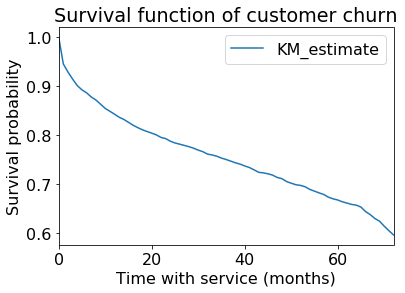

In [49]:
kmf.survival_function_.plot()
plt.title('Survival function of customer churn');
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- What is this plot telling us?
- It is the probability of survival over time.
- This is around 0.6 at the end, but...

In [50]:
np.mean(y_train == 'No')

0.7355168496781522

- ...but 73% of customers "survived" in our dataset. So, shouldn't our plot go down to 73%
- It goes lower, to ~60%, because some customers churned in less than 70 months.
- Thus, the _probability_ of churning in 70 months is larger than our fraction who churned.
  - Or, conversely, the probability of survival is lower than the fraction of stayed.

The key point here is that people _joined at different times_:

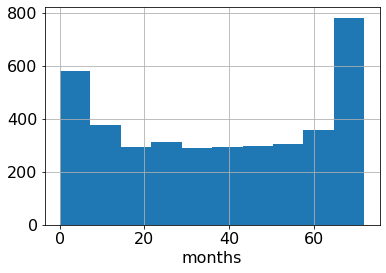

In [59]:
df_train[y_train == 'No']["tenure"].hist();
plt.xlabel('months');

Lifelines can also give us some "error bars":

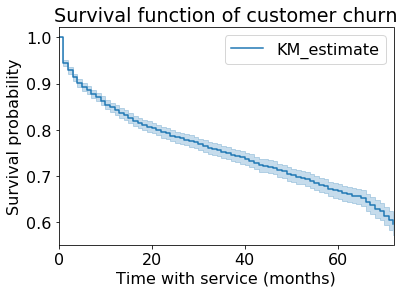

In [51]:
kmf.plot();
plt.title('Survival function of customer churn');
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- We already have some actionable information here.
- As an aside, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 57000 times!

We can also create the K-M curve for different subgroups:

In [53]:
T = df_train_surv["tenure"]
E = df_train_surv["Churn"]
senior = df_train_surv["SeniorCitizen_1"] == 1

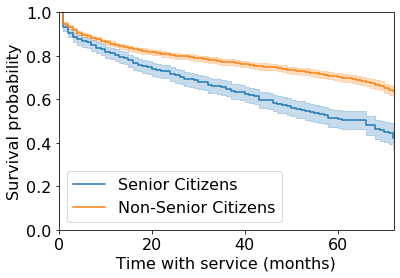

In [54]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

#### Why not just predict `tenure`?

- A question is, why don't we just do regression on the `tenure` column instead of classification on the `Churn` column? Discuss for 1-2 min.

<br><br><br><br><br><br>

This still doesn't work - we conflate the following situations:

1. Someone who joined 2 months before the data was collected
2. Someone who churned after 2 months

## Break (5 min)

## Cox proportional hazards model (10 min)

- The Cox proportional hazards model is a commonly used model that allows us to interpret how predictors influence a censored response. 
- You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won't go into this here.
- The proportional hazard model works multiplicately, like linear regression with log-transformed targets.

In [60]:
cph = lifelines.CoxPHFitter()
cph.fit(df_train_surv, duration_col='tenure', event_col='Churn');

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

- Ok, going that [that URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - FYI this is related to switching from `LinearRegression` to `Ridge` or `Lasso` ().
  - (For 340 folks: we're adding regularization; `lifelines` adds both L1 and L2 regularization, aka elastic net)
  - I could have also look at pandas-profiler and tried to see which features are the collinear ones. 
- (I'm trying something out pedagogically, where I show you all the things that went wrong for me, instead of the cleaned up version)

In [61]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(df_train_surv, duration_col='tenure', event_col='Churn');

In [ ]:
# cph.params_ # coefficients

In [ ]:
# cph.baseline_hazard_ # baseline hazard

In [62]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
MonthlyCharges,-0.004324,0.995685,0.039335,-0.081419,0.072771,0.921808,1.075484,-0.109929,9.124657e-01,0.132158
TechSupport_No internet service,-0.192894,0.824570,0.099888,-0.388670,0.002882,0.677958,1.002887,-1.931108,5.346975e-02,4.225133
TechSupport_Yes,-0.450211,0.637494,0.058003,-0.563894,-0.336528,0.568989,0.714246,-7.761918,8.365441e-15,46.764480
OnlineBackup_No internet service,-0.192894,0.824570,0.099888,-0.388670,0.002882,0.677958,1.002887,-1.931108,5.346975e-02,4.225133
OnlineBackup_Yes,-0.491085,0.611962,0.051016,-0.591075,-0.391096,0.553732,0.676315,-9.626081,6.205076e-22,70.448969
...,...,...,...,...,...,...,...,...,...,...
InternetService_No,-0.192894,0.824570,0.099888,-0.388670,0.002882,0.677958,1.002887,-1.931108,5.346975e-02,4.225133
DeviceProtection_No internet service,-0.192894,0.824570,0.099888,-0.388670,0.002882,0.677958,1.002887,-1.931108,5.346975e-02,4.225133
DeviceProtection_Yes,-0.332754,0.716947,0.051999,-0.434669,-0.230838,0.647479,0.793868,-6.399277,1.561141e-10,32.576680
StreamingMovies_No internet service,-0.192894,0.824570,0.099888,-0.388670,0.002882,0.677958,1.002887,-1.931108,5.346975e-02,4.225133


- Interpretation of the coefficients: changing a feature by 1 unit causes a multiplicative "change in hazard" by exp(coef). 
  - We're sweeping some details under the rug here.
- Note that, as discussed in Lecture 9, if $\textrm{coef}>0$ then $\exp(\textrm{coef})>1$.


In [63]:
cph.summary.sort_values(by="coef", ascending=False).head(5)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
PaymentMethod_Electronic check,0.444710,1.560037,0.054031,0.338812,0.550608,1.403279,1.734307,8.230691,1.861365e-16,52.254489
InternetService_Fiber optic,0.317678,1.373933,0.061073,0.197977,0.437378,1.218935,1.548642,5.201627,1.975512e-07,22.271270
PaymentMethod_Mailed check,0.265656,1.304286,0.068771,0.130868,0.400443,1.139817,1.492486,3.862929,1.120354e-04,13.123758
PaperlessBilling_Yes,0.191178,1.210675,0.052328,0.088616,0.293740,1.092661,1.341435,3.653422,2.587679e-04,11.916053
PhoneService_Yes,0.034471,1.035072,0.116630,-0.194121,0.263062,0.823559,1.300908,0.295556,7.675689e-01,0.381632


- Looking above, it seems that `PaymentMethod_Electronic check` is the most associated with churning - a 50% boost.
- Looking below, it seems that having a contract is the most associated with **not** churning - that makes sense!
  - And indeed a two year contract is better than one.

In [64]:
cph.summary.sort_values(by="coef", ascending=False).tail(5)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
TechSupport_Yes,-0.450211,0.637494,0.058003,-0.563894,-0.336528,0.568989,0.714246,-7.761918,8.365441e-15,46.764480
OnlineBackup_Yes,-0.491085,0.611962,0.051016,-0.591075,-0.391096,0.553732,0.676315,-9.626081,6.205076e-22,70.448969
OnlineSecurity_Yes,-0.529124,0.589121,0.057166,-0.641167,-0.417081,0.526678,0.658967,-9.255968,2.122982e-20,65.352470
Contract_One year,-0.813056,0.443501,0.066131,-0.942671,-0.683442,0.389586,0.504876,-12.294610,9.682312e-35,112.992132
Contract_Two year,-1.166472,0.311464,0.073747,-1.311013,-1.021930,0.269547,0.359900,-15.817231,2.366764e-56,184.785058


Could we have gotten this type of information out of sklearn?

In [65]:
lr_coefs = pd.DataFrame(data=np.squeeze(lr.coef_), index=X_train.columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
InternetService_Fiber optic,1.019364
TotalCharges,0.606862
MultipleLines_Yes,0.364731
PaperlessBilling_Yes,0.359263
StreamingMovies_Yes,0.341174
...,...
MonthlyCharges,-0.320800
TechSupport_Yes,-0.349197
Contract_One year,-0.675538
Contract_Two year,-1.292785


- The negative coefficients seem to agree.
- The positive coefficients not so much.
- But our survival model is much more useful.
  - Not to mention more correct.
- One thing we get with `lifelines` is confidence intervals on the coefficients:

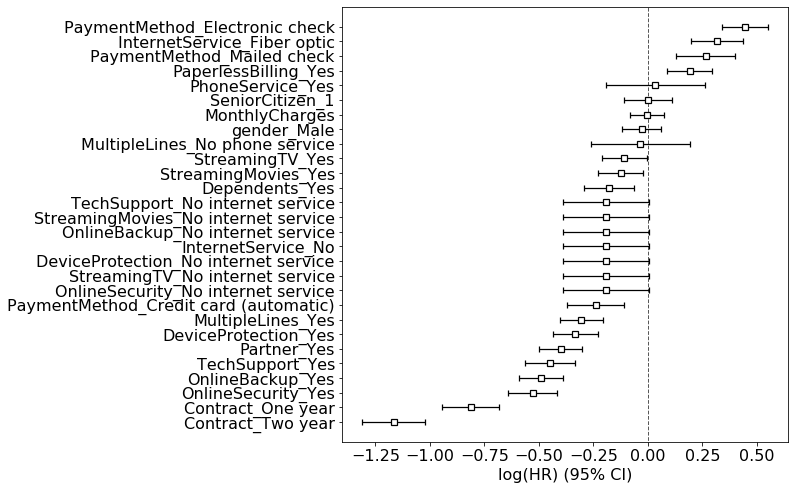

In [66]:
plt.figure(figsize=(8,8))
cph.plot();

- (We could probably get the same for logistic regression if using `statsmodels` instead of sklearn.)
- However, in general, I would be careful with all of this.
- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.
- But I think it's very useful to know about survival analysis and the availability of software to deal with it.
- Oh, and there are lots of other nice plots.

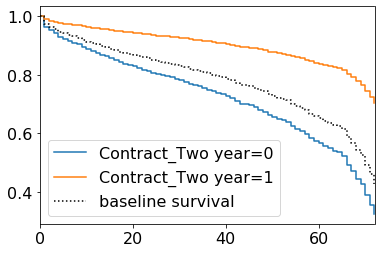

In [67]:
cph.plot_covariate_groups('Contract_Two year', [0, 1]);

## Prediction (10 min)

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn:

In [68]:
cph.predict_expectation(df_test_surv).head()

4617    53.071322
6319    37.291898
1019    48.748157
6787    57.454333
3940    28.710179
dtype: float64

Survival curves for test set:

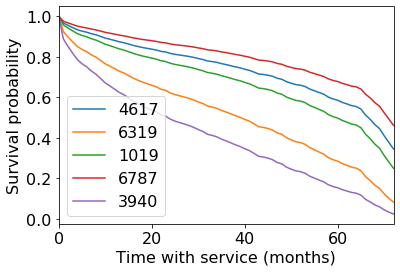

In [69]:
cph.predict_survival_function(df_test_surv[:5]).plot();
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- There's no probability prerequisite for this course, so this is optional material.
- But you can do some interesting stuff here with conditional probabilities.
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

In [70]:
df_train_not_churned = df_train_surv[~df_train_surv["Churn"]]

In [71]:
df_train_not_churned[-1:]["tenure"]

149    15
Name: tenure, dtype: int64

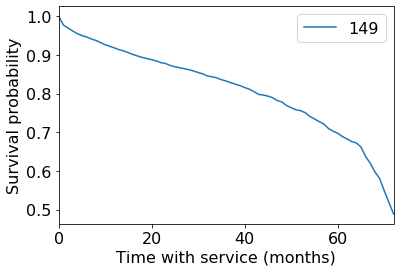

In [72]:
cph.predict_survival_function(df_train_not_churned[-1:]).plot();
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

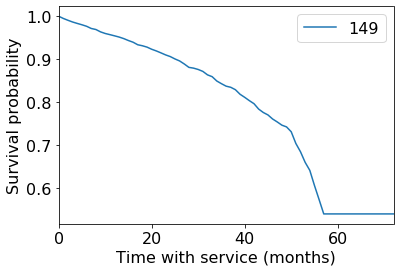

In [73]:
cph.predict_survival_function(df_train_not_churned[-1:], conditional_after=df_train_not_churned['tenure'][-1:]).plot();
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 47 months.
- About the lines flattening, we have a problem that we've never seen anyone churn after 6 years:

In [74]:
df_train_surv["tenure"].max()

72

We can fix that by fiddling with the data (maybe I'll get to this before next class).

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

## Other approaches / what did we not cover? (5 min)

- Measures of model accuracy (may add this)

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

There are also various types and sub-types of censoring we didn't cover:

- Sub-types within right consoring
  - Did everyone join at the same time?
  - Other there other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## True/False questions (10 min)

1. If all customers joined a service at the same time (hypothetically), then censoring would not be an issue.
2. If a customer is censored after 5 months with the service, then all customers are censored after 5 months (i.e. no values of `tenure` above 5).
3. The Cox proportional hazards model (`cph` above) assumes the effect of a feature is the same for all customers and over all time.
4. Survival analysis can be useful even without a "deployment" stage.

<br><br><br><br><br><br>

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis